In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
lakshmi25npathi_imdb_dataset_of_50k_movie_reviews_path = kagglehub.dataset_download('lakshmi25npathi/imdb-dataset-of-50k-movie-reviews')

print('Data source import complete.')


100%|██████████| 25.7M/25.7M [00:02<00:00, 12.0MB/s]

Extracting files...


Data source import complete.


# Sentiment Analysis using LSTM

## What is Sentiment Analysis:
the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.

I think this result from google dictionary gives a very succinct definition. I don’t have to re-emphasize how important sentiment analysis has become. So, here we will build a classifier on IMDB movie dataset using a Deep Learning technique called RNN.

I’m outlining a step-by-step process for how Recurrent Neural Networks (RNN) can be implemented using Long Short Term Memory (LSTM) architecture:

1. Load in and visualize the data
2. Data Processing — convert to lower case, Remove punctuation etc.
5. Tokenize — Create Vocab to Int mapping dictionary
6. Tokenize — Encode the words
7. Tokenize — Encode the labels
8. Analyze Reviews Length
9. Removing Outliers — Getting rid of extremely long or short reviews
10. Padding / Truncating the remaining data
11. Training, Validation, Test Dataset Split
12. Dataloaders and Batching
13. Define the LSTM Network Architecture
14. Define the Model Class
15. Training the Network
16. Testing

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
import re
import string
from collections import Counter
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 1) Load in and visualize the data

In [ ]:
df = pd.read_csv('/content/sample_data/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 2) Data Processing — convert to lower case, Remove punctuation etc

In [ ]:
def data_preprocessing(text):
    text = text.lower()
    text = re.sub('<.*?>', '', text) # Remove HTML from text
    text = ''.join([c for c in text if c not in string.punctuation])# Remove punctuation
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    return text

df['cleaned_reviews'] = df['review'].apply(data_preprocessing)
df.head()

,review,sentiment,cleaned_reviews
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


## 5) Tokenize — Create Vocab to Int mapping dictionary
In most of the NLP tasks, you will create an index mapping dictionary in such a way that your frequently occurring words are assigned lower indexes. One of the most common way of doing this is to use Counter method from Collections library.

In [ ]:
corpus = [word for text in df['cleaned_reviews'] for word in text.split()]
count_words = Counter(corpus)
sorted_words = count_words.most_common()

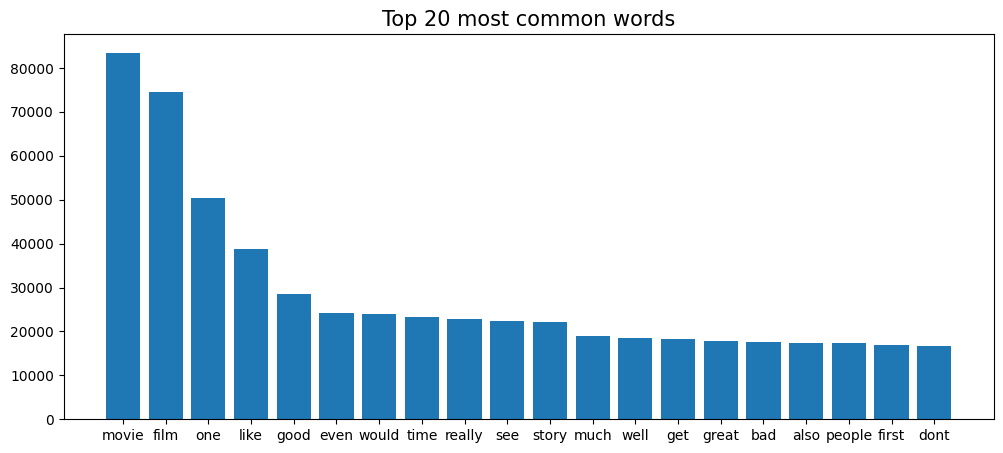

In [ ]:
keys = []
values = []
for key, value in sorted_words[:20]:
    keys.append(key)
    values.append(value)

plt.figure(figsize=(12, 5))
plt.bar(keys, values)
plt.title('Top 20 most common words', size=15)
plt.show()

There is a small trick here, in this mapping index will start from 0 i.e. mapping of ‘the’ will be 0. But later on we are going to do padding for shorter reviews and conventional choice for padding is 0. So we need to start this indexing from 1

In [ ]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

reviews_int = []
for text in df['cleaned_reviews']:
    r = [vocab_to_int[word] for word in text.split()]
    reviews_int.append(r)

print(reviews_int[:1])
df['Review int'] = reviews_int

[[3, 1809, 941, 56, 398, 3216, 286, 349, 3024, 107, 482, 471, 7412, 19, 57, 3097, 3216, 5384, 14831, 50, 473, 180, 107, 549, 52, 1605, 41, 8024, 5580, 11453, 41, 2358, 5834, 5492, 1339, 276, 473, 3259, 246, 233, 60896, 353, 3216, 11120, 240, 15438, 6674, 2418, 939, 60897, 2482, 1247, 24496, 422, 4557, 2375, 1080, 6877, 2828, 12558, 298, 60898, 16892, 213, 4901, 3569, 422, 236, 83230, 8153, 39824, 14832, 4989, 7605, 2318, 16893, 60899, 224, 8951, 7194, 12973, 8403, 33774, 34, 126, 21145, 7, 45, 166, 1173, 41, 551, 91, 159, 154, 436, 2842, 704, 84, 1144, 4165, 2352, 975, 704, 1282, 704, 83231, 58, 853, 87, 19, 286, 43, 103, 3097, 1451, 2067, 288, 45, 1422, 174, 1336, 1122, 3216, 88, 9930, 213, 1949, 1961, 473, 473, 7674, 6878, 4782, 13673, 2798, 31538, 6770, 13673, 380, 500, 14, 140, 13, 9589, 633, 694, 6770, 543, 1080, 19845, 551, 439, 809, 1860, 1080, 444, 56, 3216, 98, 302, 3602, 3115, 83232, 14, 1083, 3862, 392]]


## 7) Tokenize — Encode the labels
This is simple because we only have 2 output labels. So, we will just label ‘positive’ as 1 and ‘negative’ as 0

In [ ]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df.head()

,review,sentiment,cleaned_reviews,Review int
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching 1 oz episode ...,"[3, 1809, 941, 56, 398, 3216, 286, 349, 3024, ..."
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...,"[277, 37, 252, 1234, 2863, 17758, 83233, 1501,..."
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...,"[96, 277, 26, 988, 8, 782, 1348, 2347, 1065, 8..."
3,Basically there's a family where a little boy ...,0,basically theres family little boy jake thinks...,"[572, 124, 136, 37, 327, 3493, 1071, 124, 908,..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...,"[83238, 33775, 35, 8, 187, 2020, 1251, 2, 29, ..."


## 8) Analyze Reviews Length

In [ ]:
review_len = [len(x) for x in reviews_int]
df['Review len'] = review_len
df.head()

,review,sentiment,cleaned_reviews,Review int,Review len
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching 1 oz episode ...,"[3, 1809, 941, 56, 398, 3216, 286, 349, 3024, ...",168
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...,"[277, 37, 252, 1234, 2863, 17758, 83233, 1501,...",84
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...,"[96, 277, 26, 988, 8, 782, 1348, 2347, 1065, 8...",86
3,Basically there's a family where a little boy ...,0,basically theres family little boy jake thinks...,"[572, 124, 136, 37, 327, 3493, 1071, 124, 908,...",67
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...,"[83238, 33775, 35, 8, 187, 2020, 1251, 2, 29, ...",125


count    50000.000000
mean       119.855700
std         90.096619
min          3.000000
25%         64.000000
50%         89.000000
75%        146.000000
max       1429.000000
Name: Review len, dtype: float64


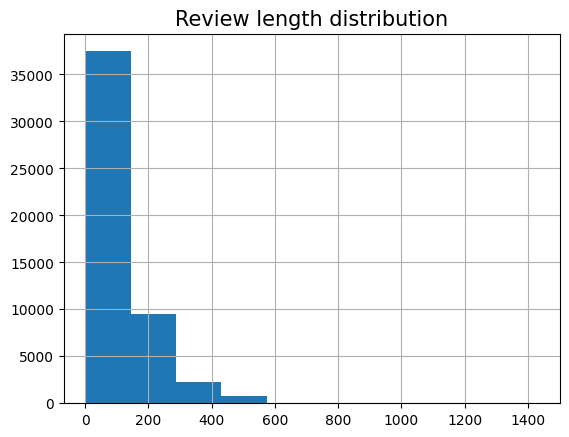

In [ ]:
print(df['Review len'].describe())

df['Review len'].hist()
plt.title('Review length distribution', size=15)
plt.show()

<b>Observations : </b>a) Mean review length = 226 b) Most of the reviews less than 500 words or more d) There are quite a few reviews that are extremely long, we can manually investigate them to check whether we need to include or exclude them from our analysis

## 10) Padding / Truncating the remaining data
To deal with both short and long reviews, we will pad or truncate all our reviews to a specific length. We define this length by Sequence Length. This sequence length is same as number of time steps for LSTM layer.

For reviews shorter than seq_length, we will pad with 0s. For reviews longer than seq_length we will truncate them to the first seq_length words.

In [ ]:
def Padding(review_int, seq_len):
    '''
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return features

In [ ]:
features = Padding(reviews_int, 200)
print(features[0, :])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     3  1809   941    56
   398  3216   286   349  3024   107   482   471  7412    19    57  3097
  3216  5384 14831    50   473   180   107   549    52  1605    41  8024
  5580 11453    41  2358  5834  5492  1339   276   473  3259   246   233
 60896   353  3216 11120   240 15438  6674  2418   939 60897  2482  1247
 24496   422  4557  2375  1080  6877  2828 12558   298 60898 16892   213
  4901  3569   422   236 83230  8153 39824 14832  4989  7605  2318 16893
 60899   224  8951  7194 12973  8403 33774    34   126 21145     7    45
   166  1173    41   551    91   159   154   436  2842   704    84  1144
  4165  2352   975   704  1282   704 83231    58   853    87    19   286
    43   103  3097  1451  2067   288    45  1422   174  1336  1122  3216
    88  9930   213  1949  1961   473   473  7674  6

## 11) Training, Validation, Test Dataset Split
Once we have got our data in nice shape, we will split it into training, validation and test sets

<b>train= 80% | valid = 10% | test = 10% </b>

In [ ]:
X_train, X_remain, y_train, y_remain = train_test_split(features, df['sentiment'].to_numpy(), test_size=0.2, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=1)

## 12) Dataloaders and Batching
After creating our training, test and validation data. Next step is to create dataloaders for this data. We can use generator function for batching our data into batches instead we will use a TensorDataset. This is one of a very useful utility in PyTorch for using our data with DataLoaders with exact same ease as of torchvision datasets

In [ ]:
# create tensor dataset
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

# dataloaders
batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

## 13) Define the LSTM Network Architecture

<img src='https://miro.medium.com/max/700/1*SICYykT7ybua1gVJDNlajw.png'>

The layers are as follows:

0. Tokenize : This is not a layer for LSTM network but a mandatory step of converting our words into tokens (integers)
1. Embedding Layer: that converts our word tokens (integers) into embedding of specific size
2. LSTM Layer: defined by hidden state dims and number of layers
3. Fully Connected Layer: that maps output of LSTM layer to a desired output size
4. Sigmoid Activation Layer: that turns all output values in a value between 0 and 1
5. Output: Sigmoid output from the last timestep is considered as the final output of this network


## 14) Define the Model Class

In [ ]:
class sentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        #embedding and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        #stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # Dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        #sigmoid function
        sig_out = self.sigmoid(out)

        # reshape to be batch size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels

        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int) + 1
output_size = 1
embedding_dim = 64
hidden_dim = 256
n_layers = 2

model = sentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)

print(model)

GPU is available
sentimentLSTM(
  (embedding): Embedding(222610, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## Training Loop

In [ ]:
import os

# Ensure the directory exists
output_dir = '../working'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

clip = 5
epochs = 2
valid_loss_min = np.inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()



    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output,labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), os.path.join(output_dir, 'state_dict.pt'))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min =epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.6032894926704466 val_loss : 0.41495623797178266
train_accuracy : 63.4425 val_accuracy : 81.92
Validation loss decreased (inf --> 0.414956).  Saving model ...
Epoch 2
train_loss : 0.32331866933964193 val_loss : 0.33272297561168673
train_accuracy : 86.58500000000001 val_accuracy : 85.56
Validation loss decreased (0.414956 --> 0.332723).  Saving model ...


## 16) Testing

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
test_h = model.init_hidden(batch_size)

model.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    test_h = tuple([each.data for each in test_h])

    inputs, labels = inputs.to(device), labels.to(device)

    output, test_h = model(inputs, test_h)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)*100))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc*100))


Test loss: 31.521
Test accuracy: 86.660


## Thank you